In [ ]:
!pip install mycolorpy

  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3873 sha256=c856d6e8d1ae507b9c50e3f4d6dae58dbb4679f74bbd5aff3361af24b2bcaf50
  Stored in directory: /root/.cache/pip/wheels/e6/a2/70/8113826487ef774503bcd38963b04b4c920deef45d7d54993e
Successfully built mycolorpy


In [ ]:
!apt-get install exiftool
!pip install git+https://github.com/detecttechnologies/thermal_base.git@main

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libposix-strptime-perl libsombok3
  libunicode-linebreak-perl
Suggested packages:
  libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl
  libposix-strptime-perl libsombok3 libunicode-linebreak-perl
0 upgraded, 6 newly installed, 0 to remove and 39 not upgraded.
Need to get 3,395 kB of archives.
After this operation, 20.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libarchive-zip-perl all 1.60-1ubuntu0.1 [84.6 kB]
Get:2 http://archive.ubuntu.

In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 3.0 MB/s 


In [33]:
# from lsat_imgread import import_image
# from dji_imgread import read_image
import matplotlib.pyplot as plt
import numpy as np
from mycolorpy import colorlist as mcp
import rasterio as rio
import numpy.ma as ma
import imutils
from thermal_base import ThermalImage

In [34]:
def normalize_data(data):
    # normalizes the data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


In [35]:
def read_image(image_path):
    """This function transforms a DJI Mavic 2 Enterprise Due drone image into a numpy array.
    input: JPG thermal image path.
    output: temperature numpy array."""

    # Uses the library thermal_base to process the DJI image.
    # (https://github.com/detecttechnologies/thermal_base)

    image = ThermalImage(image_path=image_path, camera_manufacturer="dji")

    thermal_np = image.thermal_np           # The temperature matrix as a np array
    raw_sensor_np = image.raw_sensor_np     # The raw thermal sensor excitation values # as a np array
    meta = image.meta                     # Image metadata

    # return normalize_data(raw_sensor_np), meta
    return thermal_np, meta

In [36]:
def rotate_image(img):
    # rotates image
    return imutils.rotate(img, angle=12.5)

In [37]:
def import_image(image_path, band):
    with rio.open(image_path) as img:
        image = img.read(1)
        # image_array = np.array(image, dtype="float64")
        # rotating image
        image_array = rotate_image(image)

    # converting temperatures from Kelvin to Celcius
    if band == 10:
        L = 3.3420E-04 * image_array + 0.10000
        image_array = (1321.0789 / np.log((774.8853 / L) + 1)) - 273.15
    elif band == 11:
        image_array = (1201.1442 / np.log((480.8883 / (3.3420E-04 * image_array + 0.10000)) + 1))

    # image_array = normalize_data(image_array)

    return ma.masked_less_equal(image_array, 0)

In [38]:
def compare_images(landsat, drone):
    plt.figure()
    plt.title("Histogram Comparisson")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    # bins = np.linspace(0, 1, 10)
    plt.subplot(1, 2, 1)
    plt.hist(landsat, color=mcp.gen_color(cmap="Blues", n=landsat.shape[1]))
    # plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.hist(drone, color=mcp.gen_color(cmap="Greens", n=drone.shape[1]))
    # plt.legend(loc='upper right')
    plt.show()

In [39]:
# Reading both images
landsat_image = import_image("/content/LC08_L1TP_016037_20211214_20211223_02_T1_B10.TIF", 10)
dji_image, dji_meta = read_image("/content/DJI_0354.JPG")

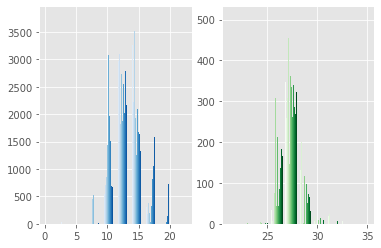

In [45]:
# Comparing images' histograms
compare_images(landsat_image, dji_image)

In [46]:
landsat_image.shape

(7771, 7641)

In [47]:
dji_image.shape

(512, 640)

In [43]:
# Trying to obtaing a correlation between the images
from scipy.stats.stats import pearsonr
import pandas as pd

In [79]:
satellite_image = pd.DataFrame(landsat_image)

def get_correlation(vals, row):
  return pearsonr(vals, dji_image[row])
for row in range(landsat_image.shape[1]):
  for row in range(dji_image.shape[0]):
    range = satellite_image[].rolling(window=dji_image.shape[1]).to_numpy()
    print(get_correlation(range, row))

TypeError: ignored